In [5]:
import kagglehub
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os

ModuleNotFoundError: No module named 'kagglehub'

In [ ]:
path = kagglehub.dataset_download("shuvoalok/raf-db-dataset")
print("Path to dataset files:", path)

100%|██████████| 60.3M/60.3M [00:03<00:00, 17.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [ ]:
# Set paths to train and test directories
train_dir = os.path.join(path, "DATASET", "train")
test_dir = os.path.join(path, "DATASET", "test")

# Simple preprocessing (just rescale, no augmentation)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load train and test data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),  # RAF-DB images are 100x100
    color_mode="rgb",       # RAF-DB uses color images
    batch_size=32,
    class_mode="categorical"
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical"
)

In [4]:
# Print example images from the training set
images, labels = next(train_data)
emotion_labels = ["Surprise", "Fear", "Disgust", "Happiness", "Sadness", "Anger", "Neutral"]
fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # Display 5 examples
for i, ax in enumerate(axes):
    ax.imshow(images[i])  # RGB images
    true_label = emotion_labels[np.argmax(labels[i])]
    ax.set_title(f"Label: {true_label}")
    ax.axis("off")
plt.suptitle("Example Images from RAF-DB Training Set")
plt.show()

NameError: name 'train_data' is not defined

In [3]:
# Define the model (unchanged except for input shape)
model = Sequential([
    Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(100, 100, 3)),  # Updated for RGB
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Flatten(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(7, activation='softmax')  # 7 emotions in RAF-DB
])

In [ ]:
# Use a learning rate scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# Compile the model
model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=40,
    callbacks=[reduce_lr, early_stop],
)

Epoch 1/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.1952 - loss: 2.4080 - val_accuracy: 0.2848 - val_loss: 1.7377 - learning_rate: 0.0010
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.2800 - loss: 1.7771 - val_accuracy: 0.3617 - val_loss: 1.7339 - learning_rate: 0.0010
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.3943 - loss: 1.5605 - val_accuracy: 0.4061 - val_loss: 1.5866 - learning_rate: 0.0010
Epoch 4/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.4501 - loss: 1.4144 - val_accuracy: 0.4925 - val_loss: 1.3078 - learning_rate: 0.0010
Epoch 5/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.4926 - loss: 1.3309 - val_accuracy: 0.5226 - val_loss: 1.2232 - learning_rate: 0.0010
Epoch 6/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.5169 - loss: 1.2728 - val_accuracy: 0.5435 - val_loss: 1.1849 - learning_rate: 0.0010
Epoch 7/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.5323 - l

In [ ]:
# Evaluate model on test data
loss, acc = model.evaluate(test_data)
print(f"Test Accuracy: {acc * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")


225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6601 - loss: 0.9035
Test Accuracy: 65.12%
Test Loss: 0.9309


In [ ]:
# Save the trained model
model.save('/content/rafdb_model.h5')
print("Model saved as 'rafdb_model.h5'")
# Download the model to your local machine
from google.colab import files
files.download('/content/rafdb_model.h5')

In [ ]:
# Reset and reload test data for accurate evaluation
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=False  # Important: no shuffling for consistent label alignment
)
y_pred = model.predict(test_data)
y_true = test_data.classes
print(classification_report(y_true, np.argmax(y_pred, axis=1), target_names=emotion_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


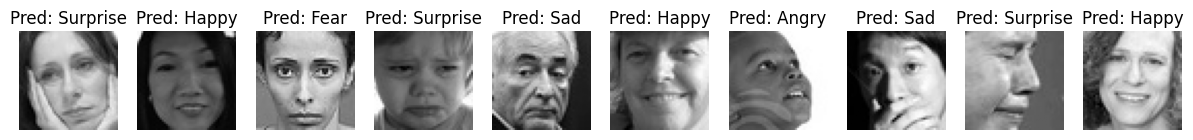

In [ ]:
images, labels = next(test_data)
predictions = model.predict(images)
predicted_labels = [emotion_labels[np.argmax(pred)] for pred in predictions]

fig, axes = plt.subplots(1, 10, figsize=(15, 6))
for i, ax in enumerate(axes):
    ax.imshow(images[i])  # RGB images
    ax.set_title(f"Pred: {predicted_labels[i]}")
    ax.axis("off")
plt.show()